In [5]:
import numpy as np
import IPython
import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as color
import soundfile
import scipy.signal as sig
import sklearn
import iracema
import math
import os
from os import listdir
import scipy.signal as sig
from os.path import isfile, join
import random

In [4]:
!pip install iracema

     |████████████████████████████████| 46 kB 868 kB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 456 kB/s eta 0:00:01
     |████████████████████████████████| 78 kB 1.0 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3


In [144]:
X = pd.read_csv('nn_ele_hb_00-24hr_TrainingSet_v2.txt', sep="\t", header=0) 


list_of_dataframes=[]

for file_path in listdir('datafiles'): 
    
    samples,sampling_rate=soundfile.read('datafiles/'+file_path)

    num_rows= np.shape(X[X['filename']==file_path])[0]
    ref_table=X[X['filename']==file_path]
    
    
    
    t_start=ref_table[ref_table.columns[2]][0:num_rows+1]
    t_end=ref_table[ref_table.columns[2]][0:num_rows+1]+ref_table[ref_table.columns[4]][0:num_rows+1]
    
    

    window_size, hop_size = int(sampling_rate*2), 1024 #need to change

    data=[]

    for i,j in zip(t_start.values.tolist(),t_end.values.tolist()):
        
        #s = samples[math.floor(i)*sampling_rate:math.ceil(j)*sampling_rate] # for filtering
        #[b,a] = sig.butter(4,[10/sampling_rate, 100/sampling_rate],'bandpass','ba') 
        #data1 = sig.filtfilt(b, a, s)
        
        
    
        audio = iracema.Audio(samples[math.floor(i)*sampling_rate:math.ceil(j)*sampling_rate], sampling_rate)
       
        #audio = iracema.Audio(data1, sampling_rate) uncomment if you want to filter and have uncommented above three lines of code
        
        fft = iracema.spectral.fft(audio, window_size, hop_size)
        pitch = iracema.pitch.hps(fft,minf0=10, maxf0=100)
        harmonics = iracema.harmonics.extract(fft, pitch)
    
        # extract some features
        data.append([iracema.features.spectral_flux(fft).data.mean(),
                 iracema.features.spectral_flatness(fft).data.mean(),
                 iracema.features.spectral_centroid(fft).data.mean(),
                 iracema.features.hfc(fft).data.mean(),
                 iracema.features.spectral_entropy(fft).data.mean(),
                 iracema.features.spectral_energy(fft).data.mean(),
                 pitch.data.mean(),
                 iracema.features.noisiness(fft,harmonics['magnitude']).data.mean(),
                 iracema.features.peak_envelope(audio, window_size, hop_size).data.mean(),
                 iracema.features.rms(audio, window_size, hop_size).data.mean(),
                 iracema.features.zcr(audio, window_size, hop_size).data.mean(),
                 iracema.features.harmonic_energy(harmonics['magnitude']).data.mean()
                ]
               )
    
    list_of_dataframes.append(ref_table.reset_index().drop('index',axis=1).join(pd.DataFrame(data)))    
    data=[]

In [145]:
df = pd.concat(list_of_dataframes)

In [146]:
df.columns = ['Selection',
  'High Freq (Hz)',
  'File Offset (s)',
  'filename',
  'duration',
  'marginals',
  'spectral_flux_avg',
  'spectral_flatness_avg',
  'spectral_centroid_avg',
  'high_frequency_content_avg',
  'spectral_entropy_avg',
  'spectral_energy_avg',
  'pitch_avg',
  'noisiness_avg',
  'peak_envelope_avg',
  'rms_avg',
  'zcr_avg',
  'harmonic_energy_avg']

In [9]:
df.head()

,Selection,High Freq (Hz),File Offset (s),filename,duration,marginals,spectral_flux_avg,spectral_flatness_avg,spectral_centroid_avg,high_frequency_content_avg,spectral_entropy_avg,spectral_energy_avg,pitch_avg,noisiness_avg,peak_envelope_avg,rms_avg,zcr_avg,harmonic_energy_avg
0,2431,49.700,1932.9301,nn06e_20180512_000000.wav,4.07,NaN,732.015883+0.000000j,-4.702457,1783.398480,10808.879685,0.359269,69718.638528,11.934732,0.998955,0.235399,0.059686,1347.281818,36.517059
1,2432,46.989,2138.5347,nn06e_20180512_000000.wav,7.31,NaN,685.714440+0.000000j,-4.704387,1728.804176,8281.871291,0.317902,66732.619362,15.821424,0.998613,0.200392,0.057791,1009.985915,48.360451
2,2433,54.800,2370.7441,nn06e_20180512_000000.wav,2.70,marginal,955.760675+0.000000j,-5.058628,1781.263438,20740.701631,0.445374,88432.567811,12.210012,0.997363,0.303748,0.068955,1531.850000,36.423982
3,2434,35.200,2844.9301,nn06e_20180512_000000.wav,4.74,NaN,1331.156985+0.000000j,-5.830248,1869.014836,43480.916848,0.522973,140822.256786,14.829615,0.999212,0.422964,0.093494,2294.654545,48.575371
0,2443,39.000,54590.7630,nn06f_20180806_000000.wav,6.21,NaN,234.883944+0.000000j,-3.627632,884.354367,133.382976,0.139689,43075.165342,19.923639,0.997759,0.084754,0.043427,0.000000,62.038618


* [Documentation](https://cegeme.github.io/iracema/source/iracema_features.html)
* [Paper](https://compmus.ime.usp.br/sbcm/2019/papers/sbcm-2019-3.pdf)
* [Github](https://github.com/cegeme/iracema)

In [124]:
X = pd.read_csv('nn_ele_hb_00-24hr_TrainingSet_v2.txt', sep="\t", header=0) 


list_of_dataframes_rand=[]

for file_path in listdir('datafiles'): 
    
    samples,sampling_rate=soundfile.read('datafiles/'+file_path)

    num_rows= np.shape(X[X['filename']==file_path])[0]
    ref_table=X[X['filename']==file_path]
    
    ref_table_rand=pd.DataFrame(ref_table['filename'])
    dur_rand=10
    tstartrand=random.sample(range(int(np.shape(samples)[0]/sampling_rate)),num_rows)
    ref_table_rand.insert(1,"File Offset Random (s)",tstartrand,True)
    ref_table_rand.insert(2,"Duration Random",dur_rand)
    
    t_start_rand=ref_table_rand[ref_table_rand.columns[1]][0:num_rows+1]
    t_end_rand=ref_table_rand[ref_table_rand.columns[1]][0:num_rows+1]+ref_table_rand[ref_table_rand.columns[2]][0:num_rows+1]
    
    
    window_size, hop_size = int(sampling_rate*2), 1024 #need to change

    
    data_rand=[]

    for i,j in zip(t_start_rand.values.tolist(),t_end_rand.values.tolist()):
        
        #s = samples[math.floor(i)*sampling_rate:math.ceil(j)*sampling_rate] # for filtering
        #[b,a] = sig.butter(4,[10/sampling_rate, 100/sampling_rate],'bandpass','ba') 
        #data1 = sig.filtfilt(b, a, s)
     

       
        audio = iracema.Audio(samples[math.floor(i)*sampling_rate:math.ceil(j)*sampling_rate], sampling_rate)
        
        #audio = iracema.Audio(data1, sampling_rate) uncomment if you want to filter and have uncommented above three lines of code
        
        fft = iracema.spectral.fft(audio, window_size, hop_size)
        pitch = iracema.pitch.hps(fft,minf0=10, maxf0=100)
        harmonics = iracema.harmonics.extract(fft, pitch)
    
        # extract some features
        data_rand.append([iracema.features.spectral_flux(fft).data.mean(),
                 iracema.features.spectral_flatness(fft).data.mean(),
                 iracema.features.spectral_centroid(fft).data.mean(),
                 iracema.features.hfc(fft).data.mean(),
                 iracema.features.spectral_entropy(fft).data.mean(),
                 iracema.features.spectral_energy(fft).data.mean(),
                 pitch.data.mean(),
                 iracema.features.noisiness(fft,harmonics['magnitude']).data.mean(),
                 iracema.features.peak_envelope(audio, window_size, hop_size).data.mean(),
                 iracema.features.rms(audio, window_size, hop_size).data.mean(),
                 iracema.features.zcr(audio, window_size, hop_size).data.mean(),
                 iracema.features.harmonic_energy(harmonics['magnitude']).data.mean()
                ]
               )
    
    list_of_dataframes_rand.append(ref_table_rand.reset_index().drop('index',axis=1).join(pd.DataFrame(data_rand)))    
    data_rand=[]
   

2430    83808
2431    10858
2432    56840
2433    51013
Name: File Offset Random (s), dtype: int64
[83808, 10858, 56840, 51013]
2442    76583
2443    31999
2444    20600
2445     9710
2446    53228
2447     9499
2448    74796
2449     6603
2450    47394
2451    48280
2452    61578
2453    29385
2454    35997
Name: File Offset Random (s), dtype: int64
[76583, 31999, 20600, 9710, 53228, 9499, 74796, 6603, 47394, 48280, 61578, 29385, 35997]
2434    42311
2435     7910
2436    64092
2437    68544
2438    14615
2439     1782
2440    22220
Name: File Offset Random (s), dtype: int64
[42311, 7910, 64092, 68544, 14615, 1782, 22220]


In [125]:
df_rand = pd.concat(list_of_dataframes_rand)


In [126]:
df_rand.columns = ['filename',
  'File Offset Random (s)',
  'Duration Random',
  'spectral_flux_avg',
  'spectral_flatness_avg',
  'spectral_centroid_avg',
  'high_frequency_content_avg',
  'spectral_entropy_avg',
  'spectral_energy_avg',
  'pitch_avg',
  'noisiness_avg',
  'peak_envelope_avg',
  'rms_avg',
  'zcr_avg',
  'harmonic_energy_avg']
df_rand

,filename,File Offset Random (s),Duration Random,spectral_flux_avg,spectral_flatness_avg,spectral_centroid_avg,high_frequency_content_avg,spectral_entropy_avg,spectral_energy_avg,pitch_avg,noisiness_avg,peak_envelope_avg,rms_avg,zcr_avg,harmonic_energy_avg
0,nn06e_20180512_000000.wav,19361,10,266.513940+0.000000j,-3.229700,1377.989791,459.529862,0.131903,45040.460964,12.016924,0.998745,0.081597,0.044764,0.000000,32.101320
1,nn06e_20180512_000000.wav,28412,10,217.531150+0.000000j,-3.983088,895.195161,204.085918,0.123682,47767.950957,12.187296,0.998828,0.100994,0.045982,5.616279,32.629589
2,nn06e_20180512_000000.wav,81294,10,2070.327639+0.000000j,-5.997221,2220.078922,104111.008978,0.614289,230254.127546,11.778402,0.999609,0.621136,0.121316,3175.813953,40.153836
3,nn06e_20180512_000000.wav,44151,10,376.504877+0.000000j,-3.928747,1165.769331,1409.371717,0.146327,86354.045562,11.687537,0.998857,0.172854,0.062393,78.587209,55.137347
0,nn06f_20180806_000000.wav,50535,10,243.165245+0.000000j,-3.560702,954.180566,183.777223,0.133419,41570.879954,12.459892,0.998327,0.084251,0.043096,0.348837,48.043618
1,nn06f_20180806_000000.wav,13351,10,331.515901+0.000000j,-2.143339,1559.296315,552.485276,0.168391,25005.656484,12.857427,0.998114,0.120299,0.033690,33.174419,34.149623
2,nn06f_20180806_000000.wav,23384,10,299.907899+0.000000j,-2.296236,1400.525026,396.581683,0.160295,25264.424020,12.675696,0.998208,0.094596,0.033806,10.389535,30.303517
3,nn06f_20180806_000000.wav,67365,10,754.659768+0.000000j,-3.072751,2023.968701,5948.846912,0.323853,48973.471283,12.573473,0.998822,0.159745,0.049617,962.552326,41.366433
4,nn06f_20180806_000000.wav,59336,10,216.361003+0.000000j,-3.578393,866.323414,91.636014,0.122406,44664.958207,12.107789,0.998563,0.074220,0.044546,0.000000,44.281174
5,nn06f_20180806_000000.wav,83055,10,739.627307+0.000000j,-4.303256,1730.125334,7681.891076,0.401509,46665.231057,12.993725,0.998713,0.206360,0.050387,1661.709302,39.044598


In [133]:
from sklearn.decomposition import PCA


In [154]:
df.head()

,Selection,High Freq (Hz),File Offset (s),marginals,spectral_flux_avg,spectral_flatness_avg,spectral_centroid_avg,high_frequency_content_avg,spectral_entropy_avg,spectral_energy_avg,pitch_avg,noisiness_avg,peak_envelope_avg,rms_avg,zcr_avg,harmonic_energy_avg
0,2431,49.700,1932.9301,NaN,732.015883,-4.702457,1783.398480,10808.879685,0.359269,69718.638528,11.934732,0.998955,0.235399,0.059686,1347.281818,36.517059
1,2432,46.989,2138.5347,NaN,685.714440,-4.704387,1728.804176,8281.871291,0.317902,66732.619362,15.821424,0.998613,0.200392,0.057791,1009.985915,48.360451
2,2433,54.800,2370.7441,marginal,955.760675,-5.058628,1781.263438,20740.701631,0.445374,88432.567811,12.210012,0.997363,0.303748,0.068955,1531.850000,36.423982
3,2434,35.200,2844.9301,NaN,1331.156985,-5.830248,1869.014836,43480.916848,0.522973,140822.256786,14.829615,0.999212,0.422964,0.093494,2294.654545,48.575371
0,2443,39.000,54590.7630,NaN,234.883944,-3.627632,884.354367,133.382976,0.139689,43075.165342,19.923639,0.997759,0.084754,0.043427,0.000000,62.038618


In [155]:
df=df.drop(['filename','duration','marginals'],axis=1)

In [149]:
df['spectral_flux_avg']=df['spectral_flux_avg'].apply(lambda x: np.real(x))

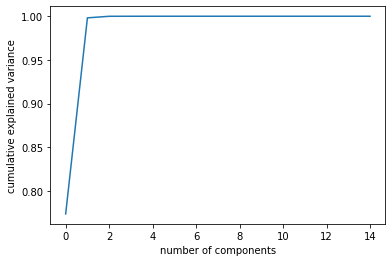

In [156]:
pca = PCA().fit(df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [139]:
df_rand=df_rand.drop(['filename','Duration Random'],axis=1)

In [142]:
df_rand['spectral_flux_avg']=df_rand['spectral_flux_avg'].apply(lambda x: np.real(x))

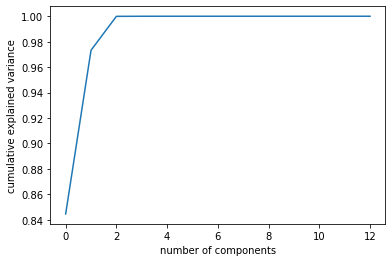

In [143]:


pca = PCA().fit(df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');